In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

sns.set(style="whitegrid")

# A+BOW Parameter Tuning

In [26]:
df = pd.read_json("/data/virgile/abow_tuning.jsonl", orient="records", lines=True)

In [27]:
df["f1"] = df.apply(lambda r: metrics.f1_score(r.ytrue, r.ypred), axis=1)
df["precision"] = df.apply(lambda r: metrics.precision_score(r.ytrue, r.ypred), axis=1)
df["recall"] = df.apply(lambda r: metrics.recall_score(r.ytrue, r.ypred), axis=1)
df["corr_diff"] = df.tr_corr - df.te_corr
df["corr_diff_round"] = df.corr_diff.round(1)

In [28]:
df.drop(labels=["yl", "ypred", "ytrue", "zl"], axis=1, inplace=True)

In [29]:
df.head()

,epoch,inv_factor,n,p,te_corr,tr_corr,use_last_model,yz_weight_ratio,f1,precision,recall,corr_diff,corr_diff_round
0,100,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.858835,0.861386,0.856299,0.045869,0.0
1,200,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.857736,0.907692,0.812992,0.045869,0.0
2,300,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.890424,0.893069,0.887795,0.045869,0.0
3,100,0.1,1.0,0.1,-0.822216,-0.776347,False,0.1,0.829582,0.910588,0.761811,0.045869,0.0
4,200,0.1,1.0,0.1,-0.822216,-0.776347,False,0.1,0.878244,0.890688,0.866142,0.045869,0.0


## Using the model from the last epoch

In [30]:
df_last = df[df.use_last_model].drop(["n", "p", "use_last_model"], axis=1)

Here we plot the F1 across all correlation differences for three hyperparameters when using the model at the last epoch:
  - `epoch`: the number of epochs the model has been trained for;
  - `inv_factor`: the scalar applied to the gradient in the reversal layer;
  - `yz_weight_ratio`: the importance of the y loss over the z loss in the model (higher value indicates a model that favors the y loss)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


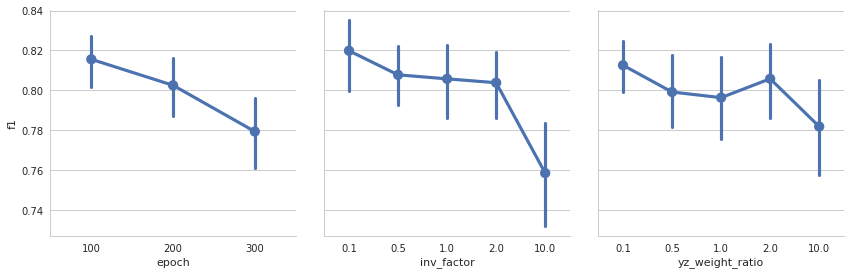

In [31]:
g = sns.PairGrid(df_last, x_vars=["epoch", "inv_factor", "yz_weight_ratio"], y_vars=["f1"], size=4)
g.map(sns.pointplot)

Looking at the picture across correlation differences, it seems that choosing `epoch=100`, `inv_factor=0.1`, and `yz_weight_ratio=0.1` yield the best results.
However, we look at the same parameters for each correlation difference values.

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


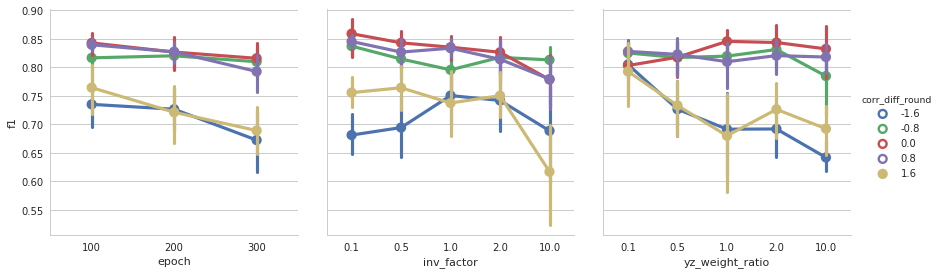

In [32]:
g = sns.PairGrid(df_last, x_vars=["epoch", "inv_factor", "yz_weight_ratio"], y_vars=["f1"], hue="corr_diff_round", size=4)
g.map(sns.pointplot, hue=df_last.corr_diff_round, palette="deep").add_legend()

## Compare tunable parameters for model selection method

In [33]:
df_modsel = df[~df.use_last_model]

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


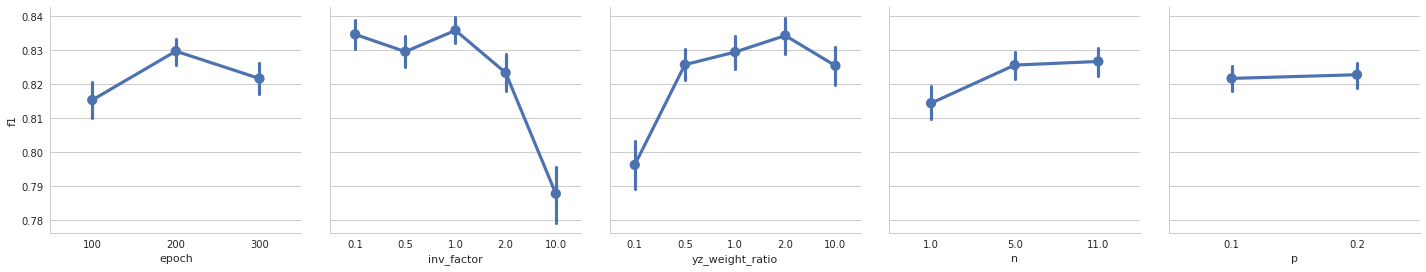

In [34]:
g = sns.PairGrid(df_modsel, x_vars=["epoch", "inv_factor", "yz_weight_ratio", "n", "p"], y_vars=["f1"], size=4)
g.map(sns.pointplot)

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


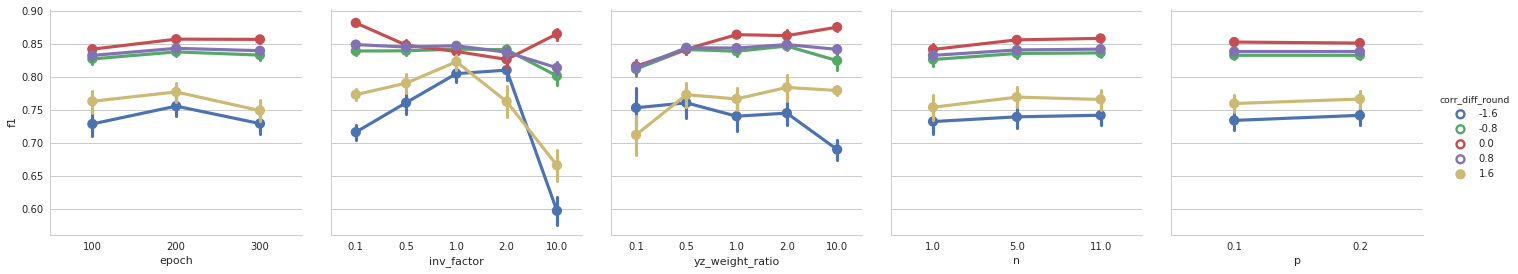

In [35]:
g = sns.PairGrid(df_modsel, x_vars=["epoch", "inv_factor", "yz_weight_ratio", "n", "p"], y_vars=["f1"], hue="corr_diff_round", size=4)
g.map(sns.pointplot, hue=df_modsel.corr_diff_round, palette="deep").add_legend()

## Compare using last model and heuristic model selection

In [48]:
df.head()

,epoch,inv_factor,n,p,te_corr,tr_corr,use_last_model,yz_weight_ratio,f1,precision,recall,corr_diff,corr_diff_round,model
0,100,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.858835,0.861386,0.856299,0.045869,0.0,ABOW
1,200,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.857736,0.907692,0.812992,0.045869,0.0,ABOW
2,300,0.1,NaN,NaN,-0.822216,-0.776347,True,0.1,0.890424,0.893069,0.887795,0.045869,0.0,ABOW
3,100,0.1,1.0,0.1,-0.822216,-0.776347,False,0.1,0.829582,0.910588,0.761811,0.045869,0.0,ABOW
4,200,0.1,1.0,0.1,-0.822216,-0.776347,False,0.1,0.878244,0.890688,0.866142,0.045869,0.0,ABOW


/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


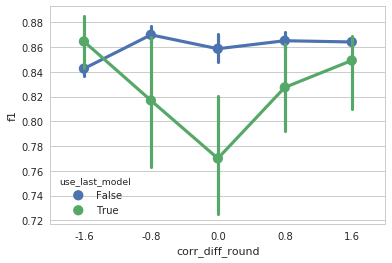

In [45]:
best_df_filter = (
    ( (df.use_last_model == False) & (df.n == 11) & (df.p == .2) & (df.yz_weight_ratio == 2) & (df.inv_factor == 2) )
    |
    ( (df.use_last_model == True) & (df.yz_weight_ratio == .1) & (df.inv_factor == 1) )
)
sns.pointplot("corr_diff_round", "f1", "use_last_model", data=df[best_df_filter])